In [74]:
import pandas as pd
import sklearn
from scipy import stats
import matplotlib.pyplot as plt

In [75]:
# Read CSV
test = pd.read_csv('test_table.csv')
user = pd.read_csv('user_table.csv')

In [76]:
# Getting an overview

In [77]:
test.describe()
# Mean conversion looks right

,user_id,conversion,test
count,453321.000000,453321.000000,453321.000000
mean,499937.514728,0.049579,0.476446
std,288665.193436,0.217073,0.499445
min,1.000000,0.000000,0.000000
25%,249816.000000,0.000000,0.000000
50%,500019.000000,0.000000,0.000000
75%,749522.000000,0.000000,1.000000
max,1000000.000000,1.000000,1.000000


In [78]:
test.test.value_counts()
# split about right

0    237338
1    215983
Name: test, dtype: int64

In [79]:
test.info()
# Some missing values in ads_channel
# This is perhaps due to unrecogenized source, we should leave it as None,
# instead of fillning with arbitrary values which could loss information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           453321 non-null  int64 
 1   date              453321 non-null  object
 2   source            453321 non-null  object
 3   device            453321 non-null  object
 4   browser_language  453321 non-null  object
 5   ads_channel       181877 non-null  object
 6   browser           453321 non-null  object
 7   conversion        453321 non-null  int64 
 8   test              453321 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 31.1+ MB


In [80]:
test.ads_channel.fillna('None',inplace =True)

In [81]:
user.describe()
# Age looks righ

,user_id,age
count,452867.000000,452867.000000
mean,499944.805166,27.130740
std,288676.264784,6.776678
min,1.000000,18.000000
25%,249819.000000,22.000000
50%,500019.000000,26.000000
75%,749543.000000,31.000000
max,1000000.000000,70.000000


In [82]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  452867 non-null  int64 
 1   sex      452867 non-null  object
 2   age      452867 non-null  int64 
 3   country  452867 non-null  object
dtypes: int64(2), object(2)
memory usage: 13.8+ MB


In [83]:
test.user_id.nunique()

453321

In [84]:
user.user_id.nunique()

452867

In [85]:
# Some users in the experiments dont have their user-level info recorded.
# Due to the minor difference, here we just drop them using inner join

In [86]:
df = pd.merge(test,user,on='user_id',how = 'inner')

In [87]:
df.sample(5)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
284697,35930,2015-12-03,SEO,Web,ES,None,FireFox,0,0,F,22,Argentina
361035,441836,2015-11-30,Ads,Mobile,ES,Google,Android_App,0,1,M,36,Mexico
150638,482939,2015-12-01,SEO,Web,ES,None,IE,0,1,F,27,Chile
282749,903931,2015-11-30,Direct,Mobile,ES,None,Android_App,0,0,F,24,Mexico
338800,890718,2015-11-30,Direct,Mobile,ES,None,Iphone_App,0,1,M,26,Mexico


In [88]:
df.groupby('date')['user_id'].count()

date
2015-11-30     70948
2015-12-01     70915
2015-12-02     70581
2015-12-03     99399
2015-12-04    141024
Name: user_id, dtype: int64

## PS, this is only 5 days of data, this is bad as it will never capture the weekly patterns, I would re-run with at least 2 weeks of data. But let's assume this is okay, and keep doing the analysis

# Ask 1: Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better

In [89]:
# Check results
print(f"Control mean conversion is: {df[df.test == 0]['conversion'].mean()}")
print(f"Test mean conversion is: {df[df.test == 1]['conversion'].mean()}")
p_value = stats.ttest_ind(
    df[df.test == 0]['conversion'],
    df[df.test == 1]['conversion'],
                       ).pvalue
print(f"P-value is {p_value}")

Control mean conversion is: 0.05515557186420519
Test mean conversion is: 0.043411161678422794
P-value is 6.085918317754031e-74


## Ok, this is weird, we improved localization, but the result seems negative.

### This is worthy a sanity check, becasue, we are talking about 1% conversion change here, which is huge and very unlikely to happen with an improvement

### I will first sanity check the randomization, making sure the control is comparable with the test. I chose to build a model to predict whether a record belongs to control or test, if the randomization is valid, the model will not have any predictive features, otherwise, something could ve gone wrong. 
### PS, One can also use achieve the samething by doing descriptive analysis, I chose not to do that as it seems boring to me, but that should definitely get the job done

In [90]:
# Chose to use one-hot encoding to show all unique values in partial dependence plot later
df_dummy = pd.get_dummies(df, 
                    prefix=['source','device','browser_language','ads_channel','browser','sex','country'], 
                    columns = ['source','device','browser_language','ads_channel','browser','sex','country'], 
                   )
df_dummy

,user_id,date,conversion,test,age,source_Ads,source_Direct,source_SEO,device_Mobile,device_Web,...,country_Guatemala,country_Honduras,country_Mexico,country_Nicaragua,country_Panama,country_Paraguay,country_Peru,country_Spain,country_Uruguay,country_Venezuela
0,315281,2015-12-03,1,0,32,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,497851,2015-12-04,0,1,21,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2,848402,2015-12-04,0,0,34,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,290051,2015-12-03,0,1,22,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4,548435,2015-11-30,0,1,19,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452862,425010,2015-12-04,0,0,50,0,0,1,0,1,...,0,0,1,0,0,0,0,0,0,0
452863,826793,2015-12-01,0,1,20,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
452864,514870,2015-12-02,0,0,25,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
452865,785224,2015-12-04,0,1,21,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
# Try to predict the control/test, conversion is irrelevant here
X = df_dummy.drop(columns=['conversion','user_id','date','test'])
y = df_dummy['test']

In [92]:
# split X and y into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [93]:
# Default param should be good to get a flavor
from sklearn.ensemble import RandomForestClassifier
random_forest_clf = RandomForestClassifier()
random_forest_clf.fit(X_train, y_train)


RandomForestClassifier()

In [94]:
y_pred = random_forest_clf.predict(X_test)

In [95]:
# check accuracy score
from sklearn.metrics import precision_score, recall_score,f1_score
print('random_forest precision_score score: {0:0.4f}'. format(precision_score(y_test, y_pred)))
print('random_forest recall_score score: {0:0.4f}'. format(recall_score(y_test, y_pred)))
print('random_forest f1_score score: {0:0.4f}'. format(f1_score(y_test, y_pred)))

from sklearn import metrics
metrics.confusion_matrix(y_test, y_pred)

random_forest precision_score score: 0.5650
random_forest recall_score score: 0.5903
random_forest f1_score score: 0.5774


array([[41464, 29496],
       [26592, 38309]])

In [96]:
# Ok, seems randomized from a high-level.
# Let's make sure at feature-level this is also true.
# I will plot the PDP
# If the randomization is achived for a feature, its values should have same amount of predicibility to test/coontrol
# Otherwise, we'd know at which features things went wrong.

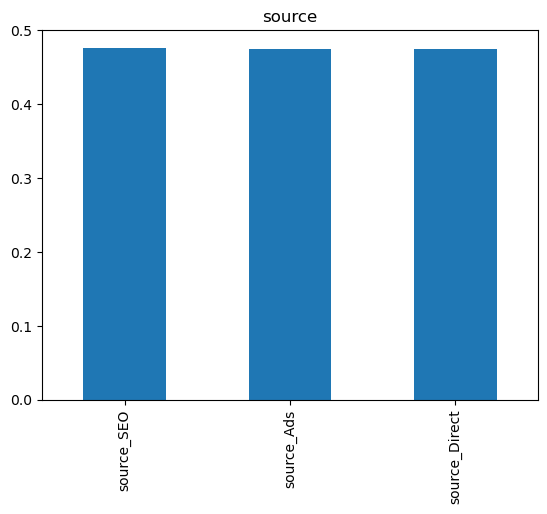

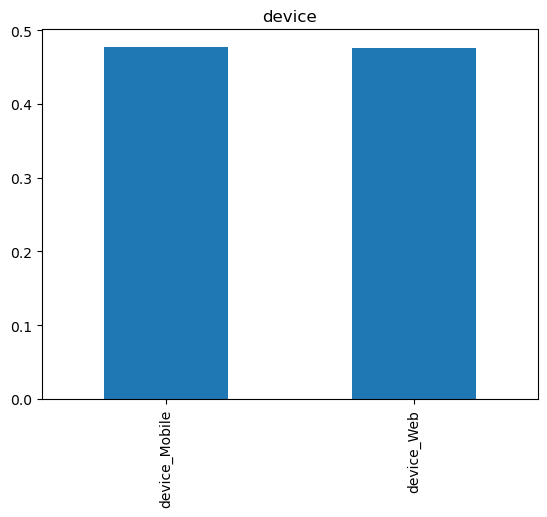

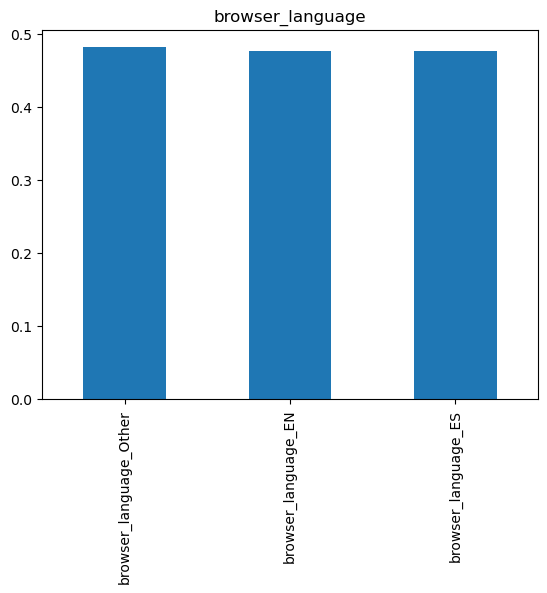

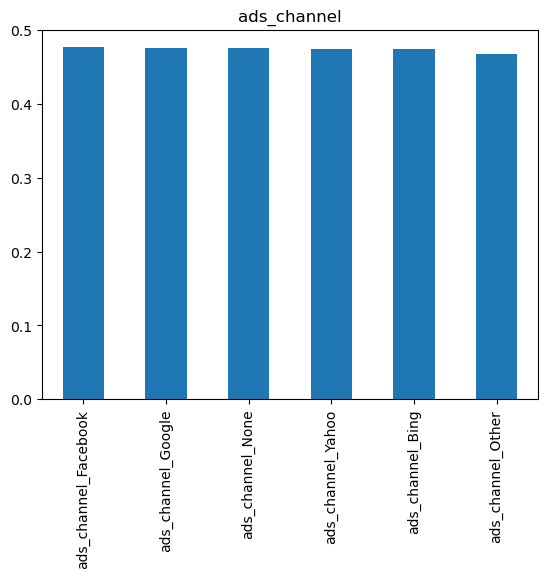

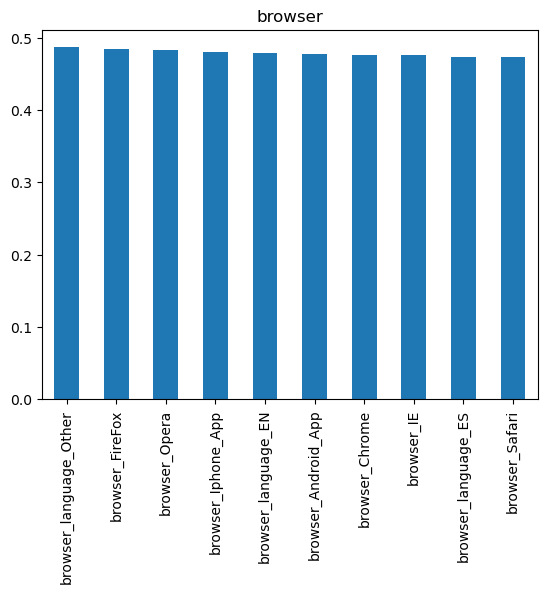

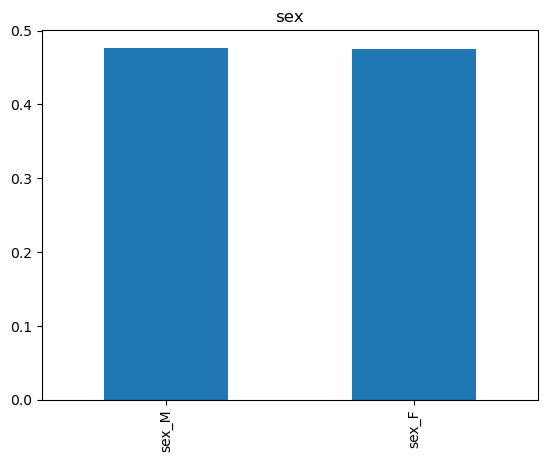

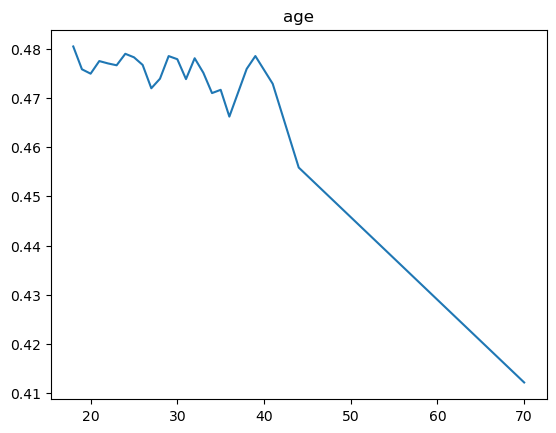

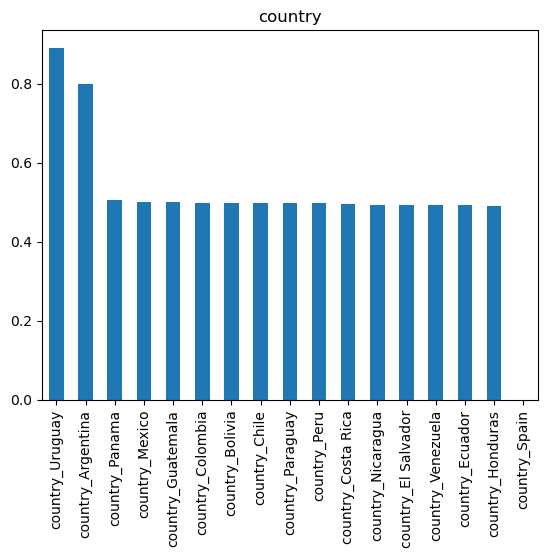

In [97]:
from pdpbox import pdp
import matplotlib.pyplot as plt
model = random_forest_clf
# plotting the partial dependence plot to explain feature importance
feat_original = df.columns.drop(['conversion','user_id','date','test'])

for i in range(len(feat_original)):
    plot_var = [col for col in list(X) if col.startswith(feat_original[i])]
    # this means it is a numerical
    if len(plot_var) ==1:
        pdp_iso = pdp.pdp_isolate(model = model,
                                 dataset= X,
                                 model_features= list(X),
                                 feature= plot_var[0],
                                 num_grid_points = 50)
        pdp_dataset = pd.Series(pdp_iso.pdp, index = pdp_iso.feature_grids)
        pdp_dataset.plot(title=feat_original[i])
        plt.show()
    else:
        pdp_iso = pdp.pdp_isolate(model = model,
                                 dataset= X,
                                 model_features= list(X),
                                 feature= plot_var,
                                 num_grid_points = 50)
        pdp_dataset = pd.Series(pdp_iso.pdp, index = pdp_iso.feature_grids)
        pdp_dataset.sort_values(ascending =False).plot(kind = 'bar',
                                                      title = feat_original[i])
        plt.show()

## Heyy, here we go.
## We find two features may be showing randomization failure, namely age and country

<AxesSubplot:xlabel='age', ylabel='Count'>

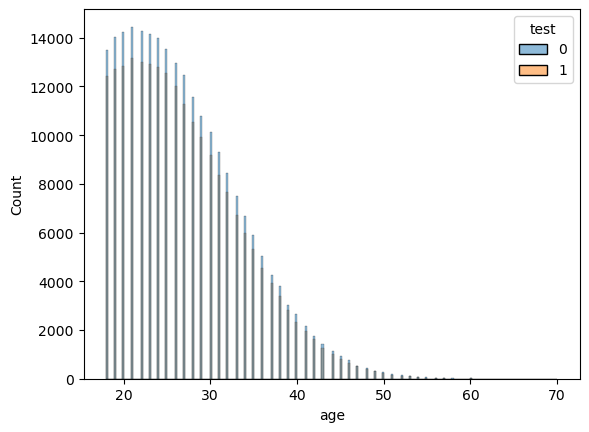

In [98]:
# Visuliza Age
import seaborn as sns
sns.histplot(data = df, x= 'age',hue = 'test')

In [99]:
# Test seems have more old ppl, but volume is very low, doubt that this is problemtic

In [100]:
print(f"control mean age: {df[df.test == 0 ].age.mean()}")
print(f"control mean age: {df[df.test == 1 ].age.mean()}")

control mean age: 27.144850332991695
control mean age: 27.115236312067257


In [101]:
# Age is hardly a problem, let's check country

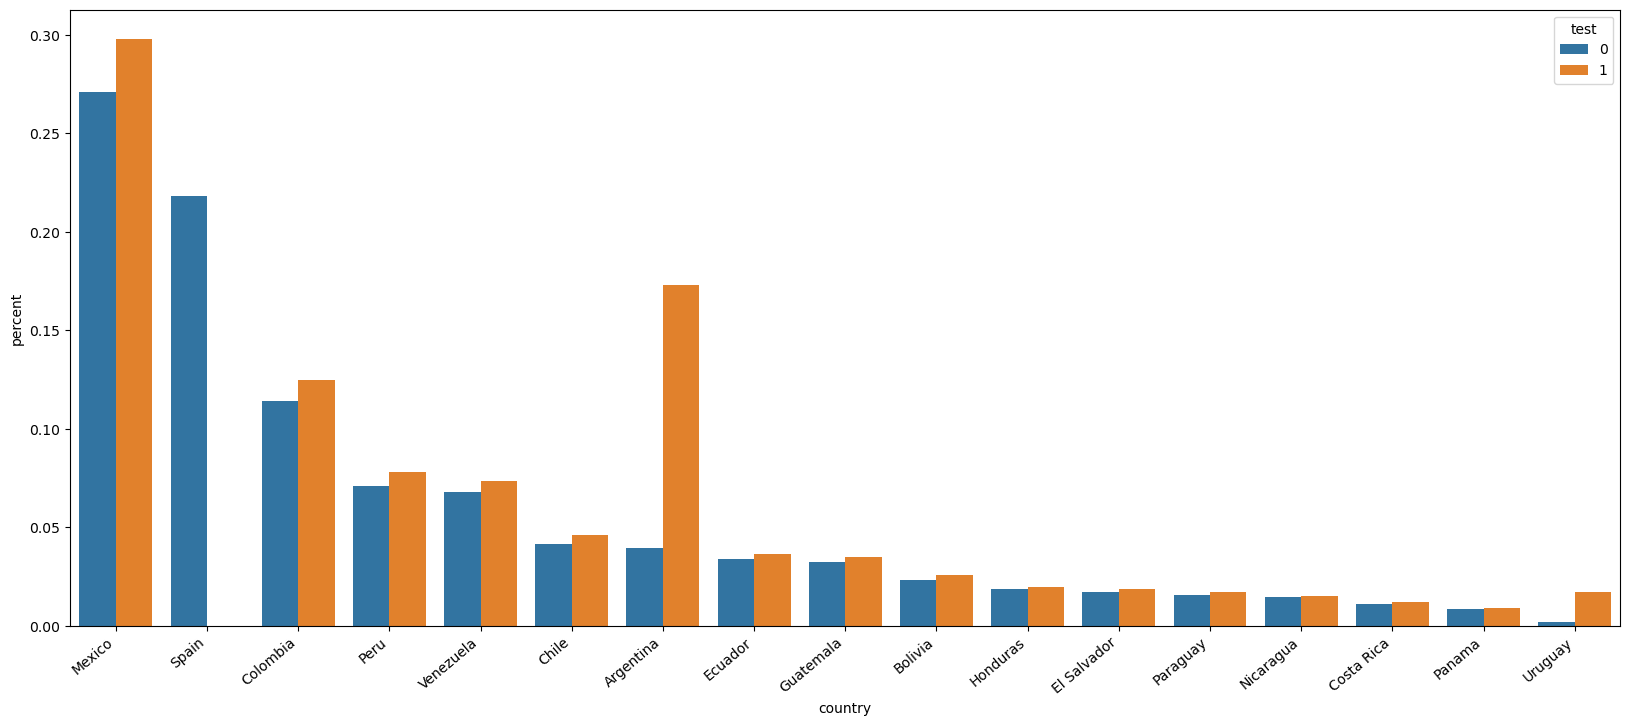

In [102]:
plt.figure(figsize=(20,8))
ax = sns.barplot(data = df.groupby(['test'])['country'].value_counts(normalize=True).to_frame( name="percent").\
reset_index(),x='country',y='percent',hue='test'
           )

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


plt.show()

## We may have got the problem
###  The control has Spain, and the test does not. It shouldn't be like this, there is no change for this silo, we should not consider it when doing the analysis.


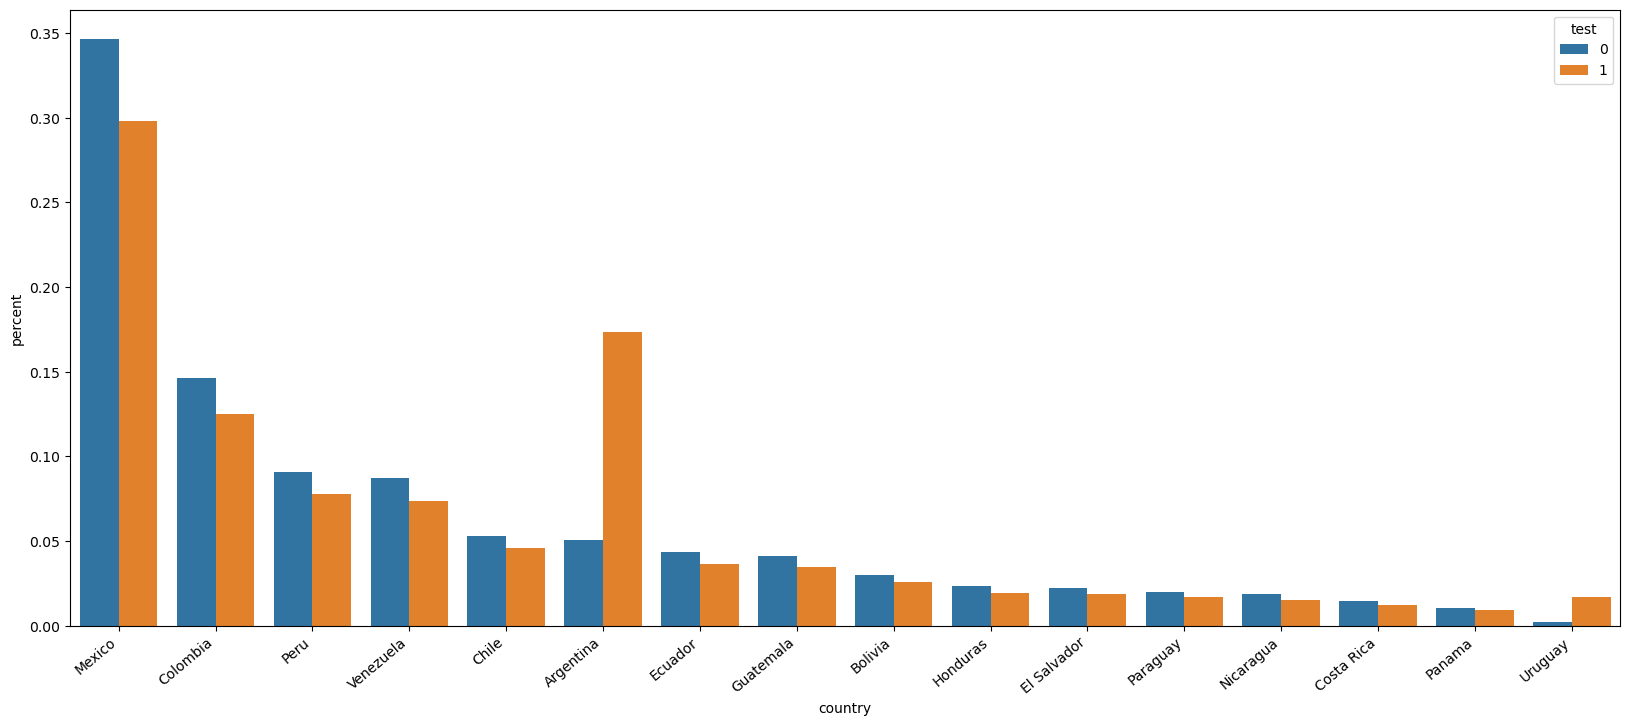

In [103]:
# Drop Spain and check the country percentage
plt.figure(figsize=(20,8))
ax = sns.barplot(data = df[df.country != 'Spain'].groupby(['test'])['country'].value_counts(normalize=True).to_frame( name="percent").\
reset_index(),x='country',y='percent',hue='test'
           )

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


plt.show()

### Test has way more users from Argentina and Uruguay, this is likely a bug. We should fix and re-run; we can also try to re-do the test without these two contries

In [104]:
df_remove_es_ar_ur = df[df.country != 'Spain'][df.country != 'Argentina'][df.country != 'Uruguay']

In [105]:
# Check results again
print(f"Control mean conversion is: {df_remove_es_ar_ur[df_remove_es_ar_ur.test == 0]['conversion'].mean()}")
print(f"Test mean conversion is: {df_remove_es_ar_ur[df_remove_es_ar_ur.test == 1]['conversion'].mean()}")
p_value = stats.ttest_ind(
    df_remove_es_ar_ur[df_remove_es_ar_ur.test == 0]['conversion'],
    df_remove_es_ar_ur[df_remove_es_ar_ur.test == 1]['conversion'],
                       ).pvalue
print(f"P-value is {p_value}")

Control mean conversion is: 0.05014811438988265
Test mean conversion is: 0.050412759477438486
P-value is 0.7200832833651563


# A-ha, the result is not significant. We should fix the above-mentioned problem, and re-run the experiment